In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import time
import nodevectors
import networkx as nx
from sklearn import mixture, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Load Lyon primary school data

In [2]:
fname = 'ia-primary-school-proximity-attr.edges'
file = open(fname)

nodes_i = []
nodes_j = []
hours = []
days = []

node_dict = {}
id_dict = {}
n_idx = 0

for line in file:
    node_i, node_j, t, id_i, id_j = line.strip('\n').split(',')
    
    if node_i not in node_dict:
        node_dict[node_i] = n_idx
        id_dict[node_i] = id_i
        n_idx += 1    

    if node_j not in node_dict:
        node_dict[node_j] = n_idx
        id_dict[node_j] = id_j
        n_idx += 1
        
    nodes_i.append(node_dict[node_i])
    nodes_j.append(node_dict[node_j])
    hours.append(int(int(t)/(60*60)))
    days.append(int(int(t)/(60*60*24)))

Construct the unfolded adjacency matrix $\mathbf{A} = (\mathbf{A}^{(1)} | \cdots | \mathbf{A}^{(T)})$ with $n=242$ nodes and $T=20$ time steps.

In [3]:
n = len(node_dict)
T = 20

As = np.zeros((T,n,n))

for i in range(len(nodes_i)):
    t = 10*int(hours[i]/24) + hours[i]%24 - 8
    As[t, nodes_i[i], nodes_j[i]] = 1
    As[t, nodes_j[i], nodes_i[i]] = 1

Generate plotting colours and markers using the school class for each student, treating teachers as their own separate group.

In [4]:
colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:6])
colours[5] = 'black'

Z_classes = np.array([{'1A':0, '1B':1, '2A':2, '2B':3, '3A':4, '3B':5, '4A':6, '4B':7, '5A':8, '5B':9, 'Teachers':10}[id_dict[node_id]] for node_id in id_dict])
Z_colours = np.array([colours[{'1':0, '2':1, '3':2, '4':3, '5':4, 'T':5}[id_dict[node_id][0]]] for node_id in id_dict])
Z_markers = np.array([{'A':'o', 'B':'^', 'e':'s'}[id_dict[node_id][1]] for node_id in id_dict])

Create legend key

In [5]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:blue', marker='o', s=12, label='Class 1A'),
           plt.scatter([],[], color='tab:blue', marker='^', s=12, label='Class 1B'),
           plt.scatter([],[], color='tab:orange', marker='o', s=12, label='Class 2A'),
           plt.scatter([],[], color='tab:orange', marker='^', s=12, label='Class 2B'),
           plt.scatter([],[], color='tab:green', marker='o', s=12, label='Class 3A'),
           plt.scatter([],[], color='tab:green', marker='^', s=12, label='Class 3B'),
           plt.scatter([],[], color='tab:red', marker='o', s=12, label='Class 4A'),
           plt.scatter([],[], color='tab:red', marker='^', s=12, label='Class 4B'),
           plt.scatter([],[], color='tab:purple', marker='o', s=12, label='Class 5A'),
           plt.scatter([],[], color='tab:purple', marker='^', s=12, label='Class 5B'),
           plt.scatter([],[], color='black', marker='s', s=12, label='Teacher')]
plt.close()

Useful function for more granulated colour maps later.

In [6]:
def categorical_cmap(nc, nsc, cmap='tab10', continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    return cols

### Unfolded node2vec embedding

Calculate the node2vec embedding of the dilated unfolded adjacency matrix $\begin{bmatrix} \mathbf{0} & \mathbf{A} \\ \mathbf{A}^\top & \mathbf{0} \end{bmatrix}$ into $d=10$ dimensions. This number makes sense as it matches the number of communities we hope to find in the data; one for each classroom.

In [7]:
def n2v_embed(As, K, n, p=1, q=1):
    """Computes the node2vec embedding for multiple adjacency snapshots"""

    # Construct the unfolded adjacency
    if len(As.shape) == 2:
        As = np.array([As[:, :]])

    if len(As.shape) == 3:
        T = len(As)
        A = As[0, :, :]
        for t in range(1, T):
            A = np.block([A, As[t]])

    # Construct the dilated unfolded adjacency matrix
    DA = np.zeros((n + n * T, n + n * T))
    DA[0:n, n:] = A
    DA[n:, 0:n] = A.T

    # Compute node2vec
    G = nx.from_numpy_matrix(DA)
    n2v_obj = nodevectors.Node2Vec(
        n_components=K,
        return_weight=1/p,
        neighbor_weight=1/q
    )
    n2v = n2v_obj.fit_transform(G)

    # Take the rows of the embedding corresponding to the right embedding ([0:n] will be left embedding)
    right_n2v = n2v[n:, :]

    YA = np.zeros((T, n, K))
    for t in range(T):
        YA[t] = right_n2v[t * n:(t + 1) * n, 0:K]

    return YA

In [8]:
d = 10

t0 = time.time()

# p and q can be experimented with
p = 1; q = 1
YA_n2v = n2v_embed(As, d, n, p, q)

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

Making walks... Done, T=5.33
Mapping Walk Names... Done, T=4.63
Training W2V... Done, T=45.53
Execution time: 57.122 seconds


In [9]:
YA = YA_n2v

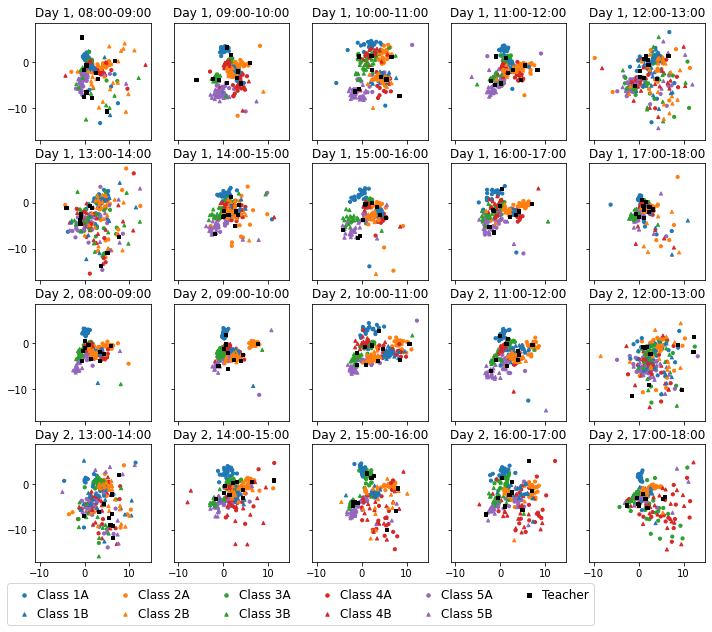

In [10]:
fig, axs = plt.subplots(4, 5, figsize=(12.0,9.6), sharex=True, sharey=True)

for m in ('o','^','s'):
    idx = np.where(Z_markers == m)[0]

    for t in range(T):
        i = int(t/5); j = t%5
        axs[i,j].scatter(YA[t,idx,0], YA[t,idx,1], marker=m, s=10, c=Z_colours[idx])
        
for t in range(T):
    i = int(t/5); j = t%5
    axs[i,j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t%10+8).zfill(2) + 
                       ':00-' + str(t%10+9).zfill(2) + ':00')

fig.legend(handles=handles, bbox_to_anchor=(0.432,0), loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.10);

### Classroom classification

Concatenate all the temporal node embeddings into a single vector per node, $\mathbf{\Theta} = (\mathbf{\Theta}^{(1)} | \cdots | \mathbf{\Theta}^{(T)}) \in \mathbb{R}^{n \times 10}$.

In [11]:
YD = YA

In [12]:
YD_concat = YD[0]

for t in range(1,T):
    YD_concat = np.block([YD_concat, YD[t]])

Fit a random forest to the concatenated embeddings for the student nodes to predict their true classroom. We generate 100 trees with a maximum of 5 features in each tree.

In [13]:
class_labels = [''] * n
for key, value in node_dict.items():
    class_labels[value] = id_dict[key]
    
class_labels = np.array(class_labels)

In [14]:
idx = np.where(class_labels != 'Teachers')[0]
YD_RF = RandomForestClassifier(max_features=5, n_estimators=100, random_state=0).fit(YD_concat[idx,:], class_labels[idx])

In [15]:
print('YD confusion matrix:')
print(metrics.confusion_matrix(class_labels[idx], YD_RF.predict(YD_concat[idx,:])))
ardi = metrics.adjusted_rand_score(class_labels[idx], YD_RF.predict(YD_concat[idx,:]))
print('Adjusted Rand index:', np.round(ardi,3))

YD confusion matrix:
[[23  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0 21  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  0  0 24]]
Adjusted Rand index: 1.0


The random forest perfectly distinguishes the 10 classrooms. We can get some idea of the robustness of the classifier but performing 10-fold cross validation.

In [16]:
t0 = time.time()

YD_RF_cvs = cross_val_score(YD_RF, YD_concat[idx,:], class_labels[idx], cv=10)
print('YD mean:', np.round(np.mean(YD_RF_cvs), 3))
print('YD st.dev.:', np.round(np.sqrt(np.var(YD_RF_cvs)), 3))

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

YD mean: 0.991
YD st.dev.: 0.017
Execution time: 1.216 seconds


We can use this random forest to predict the classroom for each of the 10 teachers in the school (we reorder them below for a clearer diagram). We do not have truth data for this labelling but we would hope that one teacher is assigned to each classroom.

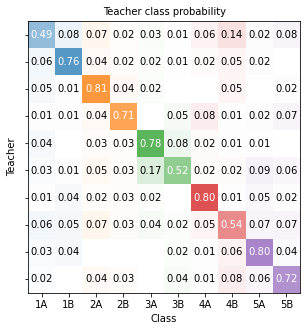

In [17]:
teachers = [188, 80, 104, 200, 168, 224, 130, 232, 180, 92]
teacher_prob = YD_RF.predict_proba(YD_concat[teachers,:])

fig, ax = plt.subplots(1, 1, figsize=(5.0,5.0))
classes = ['1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B']

prob_colours = np.zeros((10,10,4))
ccols = categorical_cmap(5, 1, cmap='tab10')
for i in range(10):
    for j in range(10):
        prob_colours[i,j,0:3] = ccols[int(j/2)]
        prob_colours[i,j,3] = teacher_prob[i,j]

ax.imshow(prob_colours)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(classes)
ax.set_yticklabels(['']*10)
ax.set_xlabel('Class')
ax.set_ylabel('Teacher')

for i in range(10):
    for j in range(10):
        if i == j:
            text = ax.text(j, i, '%.2f'%teacher_prob[i,j], ha='center', va='center', color='w')
        elif teacher_prob[i,j] >= 0.01:
            text = ax.text(j, i, '%.2f'%teacher_prob[i,j], ha='center', va='center', color='k')

ax.set_title('Teacher class probability', fontsize=10);

Using maximum a posteriori assignment, one teacher is assigned to each classroom. There is some uncertainty, especially between teachers with students in the same school year, but this does not look obviously incorrect.

### Student clustering

This time overlay the node embeddings over all time into the same space, $\mathbf{\Theta} = (\mathbf{\Theta}^{(1) \top} | \cdots | \mathbf{\Theta}^{(T) \top})^\top \in \mathbb{R}^{nT \times 10}$.

In [18]:
YD_full = YD[0]

for t in range(1,T):
    YD_full = np.block([[YD_full], [YD[t]]])

Plot the nodes to show some evidence that classrooms cluster at least for some time periods. We ignore the points near zero.

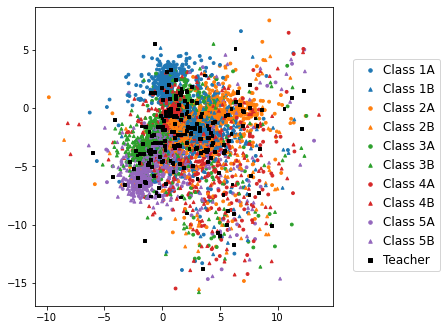

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6.5,5.5))

for m in ('o','^','s'):
    idx = np.where(np.array(list(Z_markers)*T) == m)[0]
    idx_nz = np.where(np.linalg.norm(YD_full[idx], axis=1) > 1e-10)[0]
    ax.scatter(YD_full[idx,0][idx_nz], YD_full[idx,1][idx_nz], marker=m, s=8, c=np.array(list(Z_colours)*T)[idx][idx_nz])
    
fig.legend(handles=handles, loc='center right', ncol=1, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(right = 0.76);

We want to fit a Gaussian mixture model to these 9-dimensional points to find structure in the embedding. Hopefully, we see students in the same classrooms clustering together but also detect temporal patterns of students returning to a similar spot in the embedding at different times. This is possible thanks to cross-sectional and longitudinal stability. We try 50 times to fit a Gaussian mixture model with 10-30 clusters, increasing in increments of 5 clusters. Using the Bayesian Information Criterion, we can find the best number of clusters $K$ to explain the observed data.

In [20]:
t0 = time.time()

idx_nz = np.where(np.linalg.norm(YD_full, axis=1) > 1e-10)[0]
YD_full_bic = []
K_range = range(10,31,5)

n_init = 50
for k in K_range:
    YD_full_bic.append(mixture.GaussianMixture(n_components=k, covariance_type='full', n_init=n_init).fit(YD_full[idx_nz]).bic(YD_full[idx_nz]))

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

Execution time: 157.133 seconds


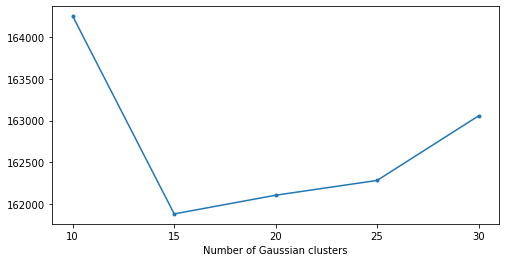

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8.0,4.0))

ax.plot(K_range, YD_full_bic, '.-')
ax.set_xticks(K_range)
ax.set_xlabel('Number of Gaussian clusters');

This time we find that the best Gaussian mixture model for the embedding has $K=25$ clusters.

In [22]:
K = 25
n_init = 50
gmm_YD_full = mixture.GaussianMixture(n_components=K, covariance_type='full', n_init=n_init, random_state=1).fit(YD_full[idx_nz])

Assign each embedding to its maximum a posteriori cluster.

In [23]:
labels = np.array([[0 for _ in range(T)] for _ in range(n)])

for ni in range(n):
    for t in range(T):
        i = ni + t*n
        if np.linalg.norm(YD_full[i]) > 1e-10:
            labels[ni,t] = gmm_YD_full.predict(YD_full[i].reshape(1,-1)) + 1

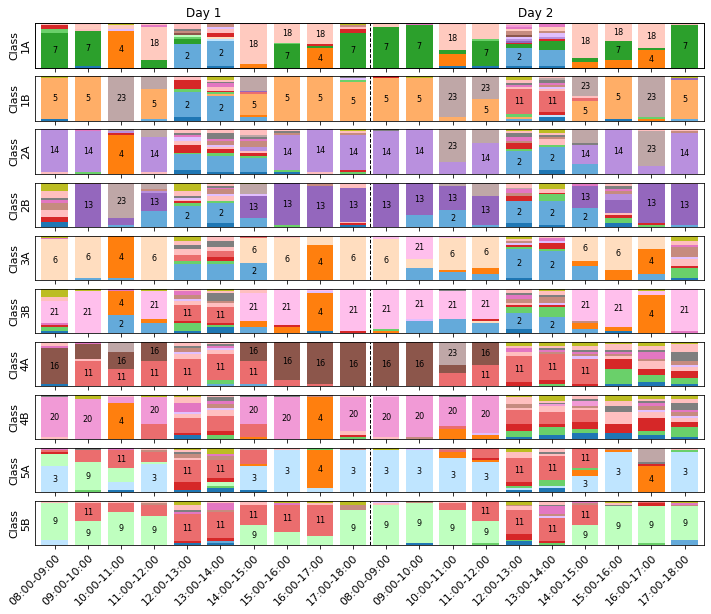

In [24]:
fig, axs = plt.subplots(10, 1, figsize=(12.0,9.6), sharex=True, sharey=True)
classes = ['1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B']
bar_colours = categorical_cmap(10, 3, cmap='tab10')

times = ['08:00-09:00','09:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00',
         '13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00',
         '08:00-09:00','09:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00',
         '13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00']
delta = 0.6

for c in range(10):
    class_name = classes[c]
    
    cluster = []
    for key, value in node_dict.items():
        if id_dict[key] == class_name:
            cluster.append(value)        
    cluster = np.array(cluster)
    
    counts = np.zeros((K,T))
    for ni in cluster:
        for t in range(T):
            if labels[ni,t] > 0:
                counts[labels[ni,t]-1,t] += 1 / len(cluster)
    
    bottom = [0] * T
    for k in range(K):
        axs[c].bar(range(T), counts[k], bottom=bottom, color=bar_colours[k])
        # Following lines add labels if required
        for t in range(T):
            if counts[k,t] >= 0.35:
                axs[c].annotate(str(k+1), xy=(t, bottom[t]+counts[k,t]/2), ha='center', va='center', fontsize=8)
        bottom += counts[k]
    
    axs[c].plot([9.5,9.5], [0,1], 'k--', linewidth=1)
    axs[c].set_xlim((-delta,19+delta))
    axs[c].set_ylim((0,1))
    axs[c].set_yticks([])
    axs[c].set_yticklabels([])
    axs[c].set_ylabel('Class\n' + class_name, fontsize=11)

axs_top = axs[0].twiny()
axs_top.set_xlim((-delta,19+delta))
axs_top.tick_params(length=0)
axs_top.set_xticks([4.5,14.5])
axs_top.set_xticklabels(['Day 1', 'Day 2'], fontsize=12)

axs[9].set_xticks(range(T))
axs[9].set_xticklabels(times, rotation=45, fontsize=11, ha='right', va='top', rotation_mode='anchor');

Similarly to the classroom classfication task, we can also assign the teachers to their most likely cluster. How the teacher moves cluster over time can be matched to the previous barchart.

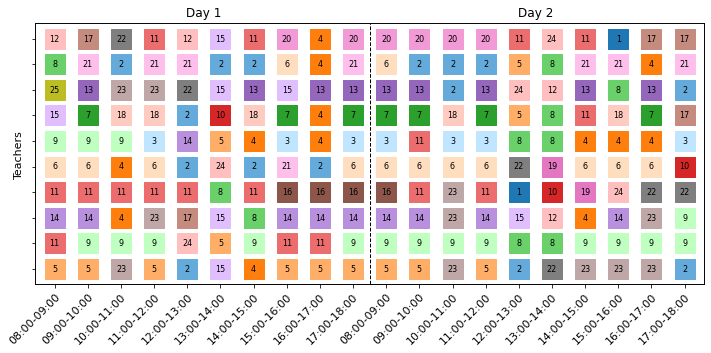

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12.0,4.8))
delta = 0.6

cluster = []
for key, value in node_dict.items():
    if id_dict[key] == 'Teachers':
        cluster.append(value)        
cluster = np.array(cluster)

for i in range(len(cluster)):
    for t in range(T):
        if labels[cluster[i],t] > 0:
            ax.scatter(t, i, marker='s', s=400, color=bar_colours[labels[cluster[i],t]-1])
            ax.annotate(str(labels[cluster[i],t]), xy=(t, i), ha='center', va='center', fontsize=8)

ax.plot([9.5,9.5], [-delta,len(cluster)-1+delta], 'k--', linewidth=1)
ax.set_xlim((-delta,19+delta))
ax.set_ylim((-delta,len(cluster)-1+delta))

ax_top = ax.twiny()
ax_top.set_xlim((-delta,19+delta))
ax_top.tick_params(length=0)
ax_top.set_xticks([4.5,14.5])
ax_top.set_xticklabels(['Day 1', 'Day 2'], fontsize=12)

ax.set_xticks(range(T))
ax.set_xticklabels(times, rotation=45, fontsize=11, ha='right', va='top', rotation_mode='anchor');
ax.set_yticks(range(len(cluster)))
ax.set_yticklabels([])
ax.set_ylabel('Teachers', fontsize=11);